In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import IPython.display as display


In [ ]:
freq_labelled = np.load('/content/drive/MyDrive/TIFR_internship /labelled.npy',allow_pickle = True,mmap_mode = 'r')
g_mode_spacing = np.load('/content/drive/MyDrive/TIFR_internship /param_2.npy',allow_pickle = True)


In [ ]:
freq_labelled = freq_labelled[0:20000]
g_mode_spacing = g_mode_spacing[0:20000]


In [ ]:
from sklearn.linear_model import Ridge
X_train, X_test, y_train, y_test = train_test_split(freq_labelled, g_mode_spacing, test_size = 0.25,random_state = 98)

In [ ]:
ridge = Ridge(solver = 'svd').fit(X_train, y_train)
print("Training set score: {:.2f}".format(ridge.score(X_train, y_train)))
print("Test set score: {:.2f}".format(ridge.score(X_test, y_test)))

Training set score: 0.40
Test set score: -0.23


In [ ]:
import math,os
plt.ioff()
plt.rc('image', cmap='gray_r')
plt.rc('grid', linewidth=1)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0', figsize=(16,9))
# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# pull a batch from the datasets. This code is not very nice, it gets much better in eager mode (TODO)
def dataset_to_numpy_util(training_dataset, validation_dataset, N):
  
  # get one batch from each: 10000 validation digits, N training digits
  batch_train_ds = training_dataset.unbatch().batch(N)
  
  # eager execution: loop through datasets normally
  if tf.executing_eagerly():
    for validation_digits, validation_labels in validation_dataset:
      validation_digits = validation_digits.numpy()
      validation_labels = validation_labels.numpy()
      break
    for training_digits, training_labels in batch_train_ds:
      training_digits = training_digits.numpy()
      training_labels = training_labels.numpy()
      break
    
  else:
    v_images, v_labels = validation_dataset.make_one_shot_iterator().get_next()
    t_images, t_labels = batch_train_ds.make_one_shot_iterator().get_next()
    # Run once, get one batch. Session.run returns numpy results
    with tf.Session() as ses:
      (validation_digits, validation_labels,
       training_digits, training_labels) = ses.run([v_images, v_labels, t_images, t_labels])
  
  # these were one-hot encoded in the dataset
  validation_labels = np.argmax(validation_labels, axis=1)
  training_labels = np.argmax(training_labels, axis=1)
  
  return (training_digits, training_labels,
          validation_digits, validation_labels)

# create digits from local fonts for testing
def create_digits_from_local_fonts(n):
  font_labels = []
  img = PIL.Image.new('LA', (28*n, 28), color = (0,255)) # format 'LA': black in channel 0, alpha in channel 1
  font1 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'DejaVuSansMono-Oblique.ttf'), 25)
  font2 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'STIXGeneral.ttf'), 25)
  d = PIL.ImageDraw.Draw(img)
  for i in range(n):
    font_labels.append(i%10)
    d.text((7+i*28,0 if i<10 else -4), str(i%10), fill=(255,255), font=font1 if i<10 else font2)
  font_digits = np.array(img.getdata(), np.float32)[:,0] / 255.0 # black in channel 0, alpha in channel 1 (discarded)
  font_digits = np.reshape(np.stack(np.split(np.reshape(font_digits, [28, 28*n]), n, axis=1), axis=0), [n, 28*28])
  return font_digits, font_labels

# utility to display a row of digits with their predictions
def display_digits(digits, predictions, labels, title, n):
  fig = plt.figure(figsize=(13,3))
  digits = np.reshape(digits, [n, 28, 28])
  digits = np.swapaxes(digits, 0, 1)
  digits = np.reshape(digits, [28, 28*n])
  plt.yticks([])
  plt.xticks([28*x+14 for x in range(n)], predictions)
  plt.grid(b=None)
  for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
    if predictions[i] != labels[i]: t.set_color('red') # bad predictions in red
  plt.imshow(digits)
  plt.grid(None)
  plt.title(title)
  display.display(fig)
  
# utility to display multiple rows of digits, sorted by unrecognized/recognized status
def display_top_unrecognized(digits, predictions, labels, n, lines):
  idx = np.argsort(predictions==labels) # sort order: unrecognized first
  for i in range(lines):
    display_digits(digits[idx][i*n:(i+1)*n], predictions[idx][i*n:(i+1)*n], labels[idx][i*n:(i+1)*n],
                   "{} sample validation digits out of {} with bad predictions in red and sorted first".format(n*lines, len(digits)) if i==0 else "", n)

def plot_learning_rate(lr_func, epochs):
  xx = np.arange(epochs+1, dtype=np.float)
  y = [lr_decay(x) for x in xx]
  fig, ax = plt.subplots(figsize=(9, 6))
  ax.set_xlabel('epochs')
  ax.set_title('Learning rate\ndecays from {:0.3g} to {:0.3g}'.format(y[0], y[-2]))
  ax.minorticks_on()
  ax.grid(True, which='major', axis='both', linestyle='-', linewidth=1)
  ax.grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
  ax.step(xx,y, linewidth=3, where='post')
  display.display(fig)

class PlotTraining(tf.keras.callbacks.Callback):
  def __init__(self, sample_rate=1, zoom=1):
    self.sample_rate = sample_rate
    self.step = 0
    self.zoom = zoom
    self.steps_per_epoch = 60000//BATCH_SIZE

  def on_train_begin(self, logs={}):
    self.batch_history = {}
    self.batch_step = []
    self.epoch_history = {}
    self.epoch_step = []
    self.fig, self.axes = plt.subplots(1, 2, figsize=(16, 7))
    plt.ioff()

  def on_batch_end(self, batch, logs={}):
    if (batch % self.sample_rate) == 0:
      self.batch_step.append(self.step)
      for k,v in logs.items():
        # do not log "batch" and "size" metrics that do not change
        # do not log training accuracy "acc"
        if k=='batch' or k=='size':# or k=='acc':
          continue
        self.batch_history.setdefault(k, []).append(v)
    self.step += 1

  def on_epoch_end(self, epoch, logs={}):
    plt.close(self.fig)
    self.axes[0].cla()
    self.axes[1].cla()
      
    self.axes[0].set_ylim(0, 1.2/self.zoom)
    self.axes[1].set_ylim(1-1/self.zoom/2, 1+0.1/self.zoom/2)
    
    self.epoch_step.append(self.step)
    for k,v in logs.items():
      # only log validation metrics
      if not k.startswith('val_'):
        continue
      self.epoch_history.setdefault(k, []).append(v)

    display.clear_output(wait=True)
    
    for k,v in self.batch_history.items():
      self.axes[0 if k.endswith('loss') else 1].plot(np.array(self.batch_step) / self.steps_per_epoch, v, label=k)
      
    for k,v in self.epoch_history.items():
      self.axes[0 if k.endswith('loss') else 1].plot(np.array(self.epoch_step) / self.steps_per_epoch, v, label=k, linewidth=3)
      
    self.axes[0].legend()
    self.axes[1].legend()
    self.axes[0].set_xlabel('epochs')
    self.axes[1].set_xlabel('epochs')
    self.axes[0].minorticks_on()
    self.axes[0].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
    self.axes[0].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
    self.axes[1].minorticks_on()
    self.axes[1].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
    self.axes[1].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
    display.display(self.fig)


In [ ]:
EPOCHS = 100
# lr decay function
def lr_decay(epoch):
  return 0.01 * math.pow(0.6, epoch)

# lr schedule callback
lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=True)

# important to see what you are doing
plot_learning_rate(lr_decay, EPOCHS)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:83: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


AttributeError: ignored

In [ ]:
import keras
from tensorflow.keras import layers

# Set random seed
tf.random.set_seed(42)

# Create a model
model = tf.keras.Sequential([
    keras.Input(shape=(30000)),
    layers.Dense(8192, activation='relu'),
    layers.Dropout(0.50),
    layers.Dense(2048, activation='relu'),
    layers.Dropout(0.50),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.50),
    layers.Dense(256, activation='relu'),
    layers.Dense(1),
])


model.compile(loss=tf.keras.losses.mae,
              optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01),
              metrics=["mae"])
history = model.fit(X_train, y_train, epochs=EPOCHS, verbose=0, validation_split=0.2,callbacks= lr_decay_callback)
history


Epoch 1: LearningRateScheduler setting learning rate to 0.01.

Epoch 2: LearningRateScheduler setting learning rate to 0.006.

Epoch 3: LearningRateScheduler setting learning rate to 0.0036.

Epoch 4: LearningRateScheduler setting learning rate to 0.0021599999999999996.

Epoch 5: LearningRateScheduler setting learning rate to 0.001296.

Epoch 6: LearningRateScheduler setting learning rate to 0.0007775999999999998.

Epoch 7: LearningRateScheduler setting learning rate to 0.0004665599999999999.

Epoch 8: LearningRateScheduler setting learning rate to 0.00027993599999999994.

Epoch 9: LearningRateScheduler setting learning rate to 0.00016796159999999993.

Epoch 10: LearningRateScheduler setting learning rate to 0.00010077695999999997.

Epoch 11: LearningRateScheduler setting learning rate to 6.0466175999999974e-05.

Epoch 12: LearningRateScheduler setting learning rate to 3.627970559999999e-05.

Epoch 13: LearningRateScheduler setting learning rate to 2.1767823359999992e-05.

Epoch 14: L

dict_keys(['loss', 'mae', 'val_loss', 'val_mae', 'lr'])


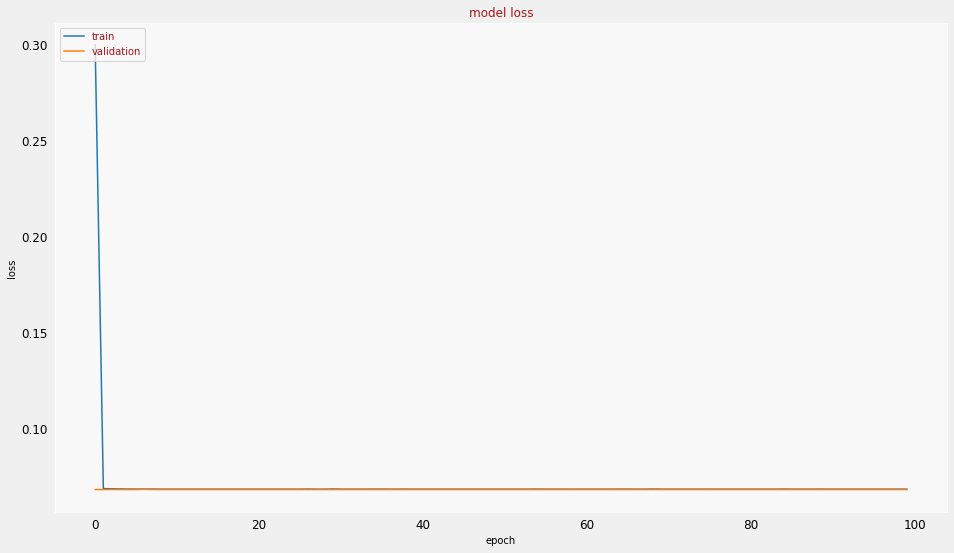

In [ ]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
y_preds = model.predict(X_test)
model.evaluate(X_test, y_test)

157/157 [==============================] - 4s 24ms/step - loss: 0.0690 - mae: 0.0690


[0.06904192268848419, 0.06904192268848419]

In [ ]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_50 (Dense)            (None, 1024)              30721024  
                                                                 
 dropout_40 (Dropout)        (None, 1024)              0         
                                                                 
 dense_51 (Dense)            (None, 512)               524800    
                                                                 
 dropout_41 (Dropout)        (None, 512)               0         
                                                                 
 dense_52 (Dense)            (None, 256)               131328    
                                                                 
 dropout_42 (Dropout)        (None, 256)               0         
                                                                 
 dense_53 (Dense)            (None, 128)             